# Thermal Modeling with Pulsim

This notebook demonstrates thermal modeling for power electronics using Pulsim.

## Contents
1. Foster Thermal Networks
2. ThermalSimulator for Transient Analysis
3. Temperature-Dependent Parameters
4. Thermal Limit Monitoring
5. Pulsed Power Analysis

## 1. Foster Thermal Networks

Pulsim uses **Foster RC networks** to model thermal behavior:

```
         R_th1        R_th2        R_th3
P_loss ──/\/\/──┬──/\/\/──┬──/\/\/──┬── T_ambient
                │         │         │
               ═══       ═══       ═══
               C_th1     C_th2     C_th3
                │         │         │
               GND       GND       GND
```

The transient thermal impedance is:
$$Z_{th}(t) = \sum_{i=1}^{n} R_{th,i} \cdot (1 - e^{-t/\tau_i})$$

where $\tau_i = R_{th,i} \cdot C_{th,i}$

**Key classes:**
- `FosterNetwork` - Defines the thermal network from Rth and tau values
- `ThermalSimulator` - Simulates junction temperature over time
- `ThermalLimitMonitor` - Monitors temperature against warning/max limits

In [1]:
import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt

# Typical Foster parameters for a TO-220 package MOSFET
# From IRF540N datasheet (approximate)
R_th = [0.18, 0.42, 0.55, 0.35]  # K/W
tau = [0.5e-3, 5e-3, 50e-3, 500e-3]  # seconds

# Create Foster thermal network
thermal_network = ps.FosterNetwork(R_th, tau, "IRF540N_JC")

print(f"Foster Network: {thermal_network.name()}")
print(f"  Number of stages: {thermal_network.num_stages()}")
print(f"  Total Rth (junction-to-case): {thermal_network.total_Rth():.2f} K/W")

# Print each stage
print("\nStage details:")
for i in range(thermal_network.num_stages()):
    stage = thermal_network.stage(i)
    print(f"  Stage {i+1}: Rth={stage.Rth:.3f} K/W, tau={stage.tau*1000:.1f} ms, Cth={stage.Cth():.4f} J/K")

Running cmake --build & --install in /Users/lgili/Documents/01 - Codes/01 - Github/PulsimCore/build/cp313-cp313-macosx_26_0_arm64
Running cmake --build & --install in /Users/lgili/Documents/01 - Codes/01 - Github/PulsimCore/build/cp313-cp313-macosx_26_0_arm64
Foster Network: IRF540N_JC
  Number of stages: 4
  Total Rth (junction-to-case): 1.50 K/W

Stage details:
  Stage 1: Rth=0.180 K/W, tau=0.5 ms, Cth=0.0028 J/K
  Stage 2: Rth=0.420 K/W, tau=5.0 ms, Cth=0.0119 J/K
  Stage 3: Rth=0.550 K/W, tau=50.0 ms, Cth=0.0909 J/K
  Stage 4: Rth=0.350 K/W, tau=500.0 ms, Cth=1.4286 J/K


### Thermal Impedance Curve (Zth)

The thermal impedance increases from 0 at t=0 to the total Rth at steady state.

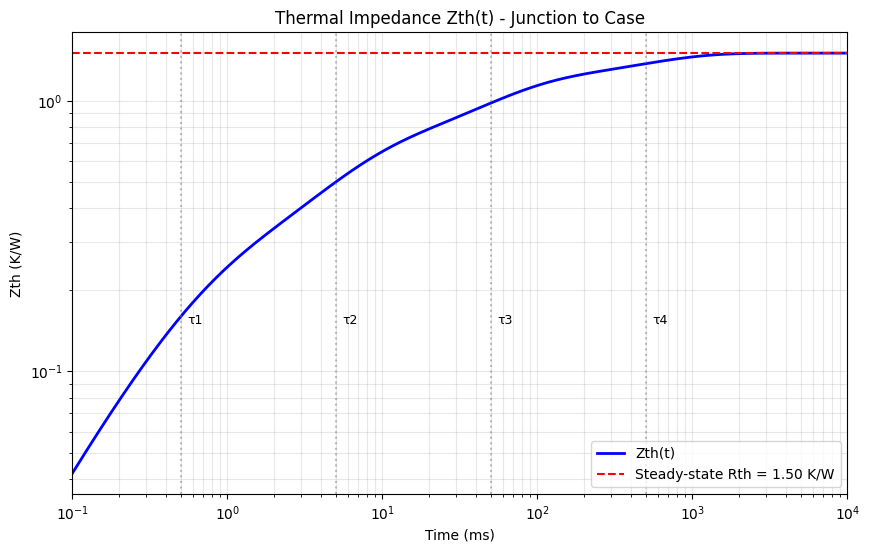

In [2]:
# Calculate and plot the thermal impedance curve Zth(t)
# Create time array spanning from microseconds to seconds
t = np.logspace(-4, 1, 500)  # 100μs to 10s

# Calculate Zth at each time point
Zth = np.array([thermal_network.Zth(ti) for ti in t])

# Plot
plt.figure(figsize=(10, 6))
plt.loglog(t * 1000, Zth, 'b-', linewidth=2, label='Zth(t)')
plt.axhline(y=thermal_network.total_Rth(), color='r', linestyle='--', 
            label=f'Steady-state Rth = {thermal_network.total_Rth():.2f} K/W')

# Mark time constants
for i, stage in enumerate([thermal_network.stage(j) for j in range(thermal_network.num_stages())]):
    plt.axvline(x=stage.tau * 1000, color='gray', linestyle=':', alpha=0.5)
    plt.text(stage.tau * 1000 * 1.1, thermal_network.total_Rth() * 0.1, 
             f'τ{i+1}', fontsize=9)

plt.xlabel('Time (ms)')
plt.ylabel('Zth (K/W)')
plt.title('Thermal Impedance Zth(t) - Junction to Case')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.xlim([0.1, 10000])
plt.show()

## 2. ThermalSimulator for Transient Analysis

The `ThermalSimulator` class performs time-domain thermal simulation using the Foster network model. It uses exponential integration for accurate results regardless of timestep.

In [4]:
# Create thermal simulator with Foster network
T_ambient = 25.0  # °C
simulator = ps.ThermalSimulator(thermal_network, T_ambient)

print(f"ThermalSimulator initialized:")
print(f"  Ambient temperature: {simulator.ambient():.1f}°C")
print(f"  Initial junction temperature: {simulator.Tj():.1f}°C")

# Simulate constant power dissipation
P_loss = 20.0  # Watts (constant)
t_final = 5.0  # seconds

# Create time and power arrays
dt = 1e-3  # 1ms timestep
times = np.arange(0, t_final, dt)
powers = np.ones_like(times) * P_loss

# Run simulation
Tj_history = simulator.simulate(times.tolist(), powers.tolist())

# Convert to numpy arrays
times = np.array(times)
Tj_history = np.array(Tj_history)

print(f"\nSimulation complete!")
print(f"  Final junction temperature: {Tj_history[-1]:.1f}°C")
print(f"  Expected steady-state: {T_ambient + P_loss * thermal_network.total_Rth():.1f}°C")

ThermalSimulator initialized:
  Ambient temperature: 25.0°C
  Initial junction temperature: 25.0°C

Simulation complete!
  Final junction temperature: 55.0°C
  Expected steady-state: 55.0°C


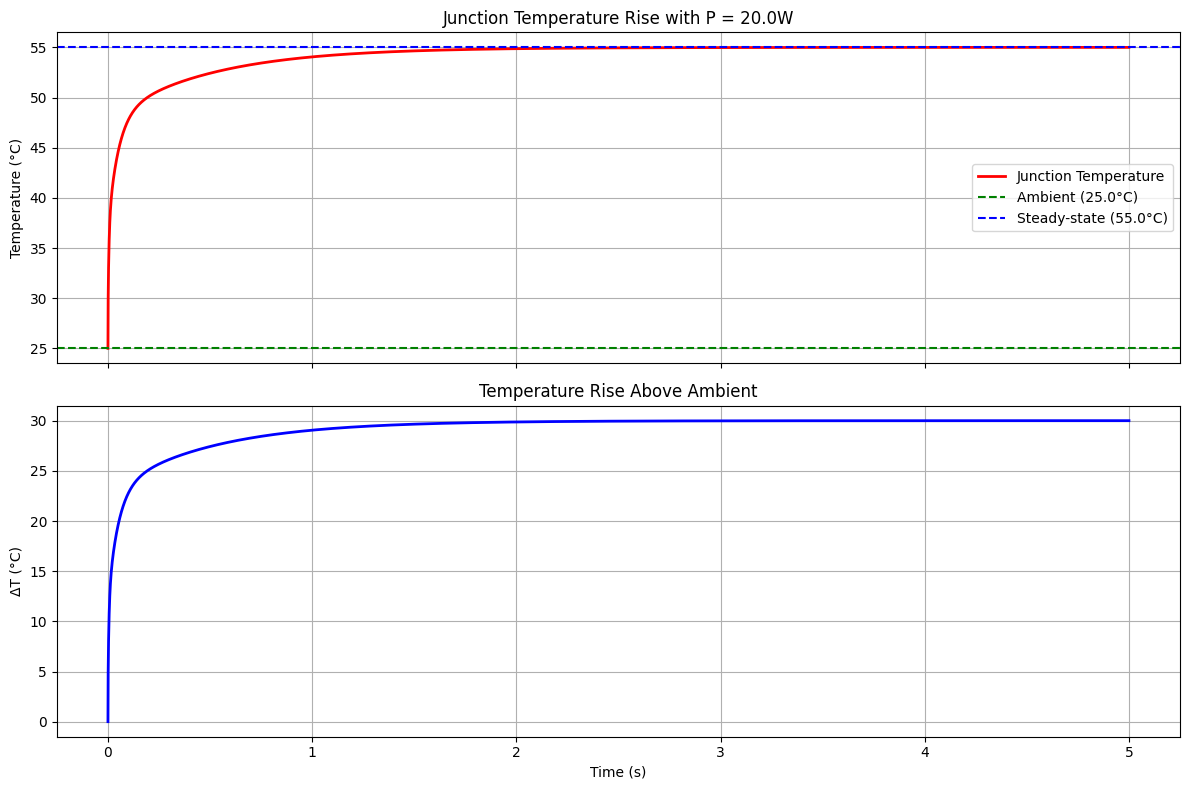


Verification with Zth(t):
  t=0.01s: Zth=0.650 K/W, ΔT_expected=13.0°C, ΔT_sim=13.0°C
  t=0.10s: Zth=1.139 K/W, ΔT_expected=22.8°C, ΔT_sim=22.8°C
  t=1.00s: Zth=1.453 K/W, ΔT_expected=29.1°C, ΔT_sim=29.1°C


In [5]:
# Plot thermal transient response
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Temperature rise
axes[0].plot(times, Tj_history, 'r-', linewidth=2, label='Junction Temperature')
axes[0].axhline(y=T_ambient, color='g', linestyle='--', label=f'Ambient ({T_ambient}°C)')
Tj_ss_expected = T_ambient + P_loss * thermal_network.total_Rth()
axes[0].axhline(y=Tj_ss_expected, color='b', linestyle='--', 
                label=f'Steady-state ({Tj_ss_expected:.1f}°C)')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title(f'Junction Temperature Rise with P = {P_loss}W')
axes[0].legend()
axes[0].grid(True)

# Temperature rise (ΔT)
delta_T = Tj_history - T_ambient
axes[1].plot(times, delta_T, 'b-', linewidth=2)
axes[1].set_ylabel('ΔT (°C)')
axes[1].set_xlabel('Time (s)')
axes[1].set_title('Temperature Rise Above Ambient')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Verify against Zth curve
print("\nVerification with Zth(t):")
for t_check in [0.01, 0.1, 1.0, 5.0]:
    idx = int(t_check / dt)
    if idx < len(times):
        Zth_expected = thermal_network.Zth(t_check)
        dT_expected = P_loss * Zth_expected
        dT_simulated = Tj_history[idx] - T_ambient
        print(f"  t={t_check:.2f}s: Zth={Zth_expected:.3f} K/W, ΔT_expected={dT_expected:.1f}°C, ΔT_sim={dT_simulated:.1f}°C")

## 3. Temperature-Dependent Parameters

Power device parameters change with temperature. The MOSFET Rds_on increases:
$$R_{ds(on)}(T) = R_{ds(on)}(25°C) \times [1 + TC_1 \times (T - 25)]$$

Pulsim provides `MOSFETLossParams` for calculating temperature-dependent losses.

In [6]:
# Create MOSFET loss parameters
mosfet_params = ps.MOSFETLossParams()
mosfet_params.Rds_on = 0.044  # 44mΩ at 25°C
mosfet_params.Rds_on_tc = 0.007  # Temperature coefficient: 0.7%/°C
mosfet_params.T_ref = 25.0  # Reference temperature

print(f"MOSFET Loss Parameters:")
print(f"  Rds_on at 25°C: {mosfet_params.Rds_on * 1000:.1f} mΩ")
print(f"  Temperature coefficient: {mosfet_params.Rds_on_tc * 100:.1f}%/°C")

# Calculate Rds_on at operating temperature
Tj_operating = Tj_history[-1]  # Use simulated junction temperature
Rds_on_hot = mosfet_params.Rds_on_at_T(Tj_operating)

print(f"\nRds_on at {Tj_operating:.0f}°C: {Rds_on_hot * 1000:.1f} mΩ")
print(f"Increase: {(Rds_on_hot / mosfet_params.Rds_on - 1) * 100:.1f}%")

# Calculate updated power loss with hot Rds_on
I_drain = 10.0  # Assume 10A drain current
P_cold = ps.ConductionLoss.resistor(I_drain, mosfet_params.Rds_on)
P_hot = ps.ConductionLoss.mosfet(I_drain, mosfet_params, Tj_operating)

print(f"\nConduction loss at {I_drain:.0f}A:")
print(f"  At 25°C: {P_cold:.2f}W")
print(f"  At {Tj_operating:.0f}°C: {P_hot:.2f}W")
print(f"  Increase: {(P_hot / P_cold - 1) * 100:.1f}%")

MOSFET Loss Parameters:
  Rds_on at 25°C: 44.0 mΩ
  Temperature coefficient: 0.7%/°C

Rds_on at 55°C: 53.2 mΩ
Increase: 21.0%

Conduction loss at 10A:
  At 25°C: 4.40W
  At 55°C: 5.32W
  Increase: 21.0%


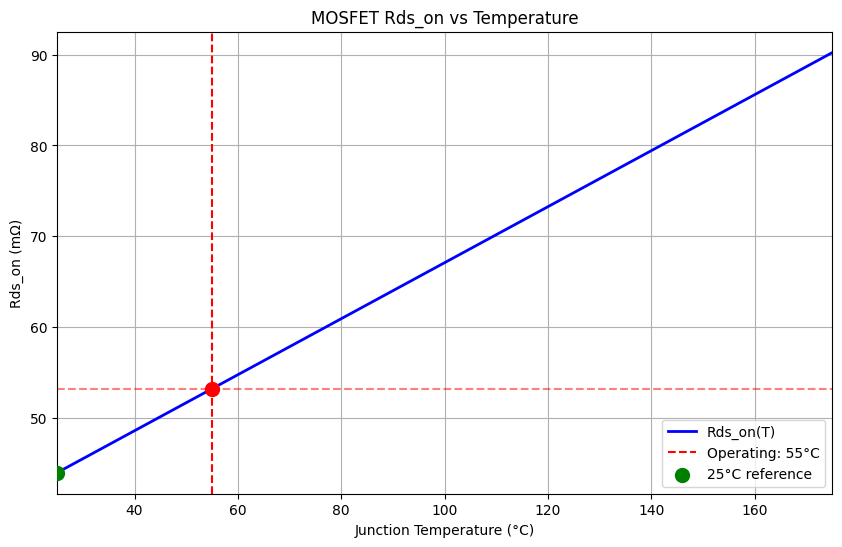

In [7]:
# Plot Rds_on vs temperature characteristic
T_range = np.linspace(25, 175, 100)
Rds_vs_T = np.array([mosfet_params.Rds_on_at_T(T) * 1000 for T in T_range])  # in mΩ

plt.figure(figsize=(10, 6))
plt.plot(T_range, Rds_vs_T, 'b-', linewidth=2, label='Rds_on(T)')
plt.axvline(x=Tj_operating, color='r', linestyle='--', label=f'Operating: {Tj_operating:.0f}°C')
plt.axhline(y=Rds_on_hot * 1000, color='r', linestyle='--', alpha=0.5)
plt.scatter([Tj_operating], [Rds_on_hot * 1000], color='r', s=100, zorder=5)
plt.scatter([25], [mosfet_params.Rds_on * 1000], color='g', s=100, zorder=5, label='25°C reference')

plt.xlabel('Junction Temperature (°C)')
plt.ylabel('Rds_on (mΩ)')
plt.title('MOSFET Rds_on vs Temperature')
plt.legend()
plt.grid(True)
plt.xlim([25, 175])
plt.show()

## 4. Thermal Limit Monitoring

The `ThermalLimitMonitor` class tracks junction temperature against warning and maximum limits. This is essential for safe operation analysis.

In [14]:
# Create thermal limit monitor
# IRF540N max junction temperature is 175°C
T_warning = 125.0  # Warning threshold
T_max = 150.0  # Maximum operating temperature (with margin below 175°C)

monitor = ps.ThermalLimitMonitor(T_max, T_warning)

print(f"ThermalLimitMonitor:")
print(f"  Warning threshold: {monitor.T_warning()}°C")
print(f"  Maximum threshold: {monitor.T_max()}°C")

 # Check each temperature point from our simulation
for Tj in Tj_history[::500]:
      status = monitor.check(Tj)
      if monitor.is_exceeded:
          print(f"EXCEEDED at {Tj:.1f}°C")
      elif monitor.is_warning:
          print(f"WARNING at {Tj:.1f}°C")
# Track peak yourself
T_peak = max(Tj_history)
print(f"\nAfter simulation:")
print(f"\nAfter simulation:")
print(f"  Peak temperature: {T_peak:.1f}°C")
print(f"  Limit exceeded: {monitor.check(T_peak), monitor.is_exceeded}")


# Test with higher power to trigger warning
print("\n--- Testing with higher power ---")
simulator2 = ps.ThermalSimulator(thermal_network, T_ambient)
P_high = 80.0  # Higher power to trigger warning
times2 = np.arange(0, 3.0, dt)
powers2 = np.ones_like(times2) * P_high
Tj_high = simulator2.simulate(times2.tolist(), powers2.tolist())

monitor2 = ps.ThermalLimitMonitor(T_max, T_warning)
for Tj in Tj_high:
    status = monitor2.check(Tj)
    if monitor2.is_exceeded:
        print(f"EXCEEDED at {Tj:.1f}°C")
    elif monitor.is_warning:
        print(f"WARNING at {Tj:.1f}°C")

print(f"With P = {P_high}W:")
T_peak = max(Tj_history)
print(f"\nAfter simulation:")
print(f"\nAfter simulation:")
print(f"  Peak temperature: {T_peak:.1f}°C")
print(f"  Limit exceeded: {monitor.check(T_peak), monitor.is_exceeded}")

ThermalLimitMonitor:
  Warning threshold: 150.0°C
  Maximum threshold: 125.0°C
EXCEEDED at 25.0°C
EXCEEDED at 52.4°C
EXCEEDED at 54.1°C
EXCEEDED at 54.7°C
EXCEEDED at 54.9°C
EXCEEDED at 55.0°C
EXCEEDED at 55.0°C
EXCEEDED at 55.0°C
EXCEEDED at 55.0°C
EXCEEDED at 55.0°C

After simulation:

After simulation:
  Peak temperature: 55.0°C
  Limit exceeded: (0, <bound method pybind11_detail_function_record_v1_system_libcpp_abi1.is_exceeded of <pulsim._pulsim.ThermalLimitMonitor object at 0x1126bb230>>)

--- Testing with higher power ---
EXCEEDED at 25.0°C
EXCEEDED at 44.5°C
EXCEEDED at 52.1°C
EXCEEDED at 57.3°C
EXCEEDED at 61.5°C
EXCEEDED at 65.1°C
EXCEEDED at 68.2°C
EXCEEDED at 70.9°C
EXCEEDED at 73.2°C
EXCEEDED at 75.2°C
EXCEEDED at 77.0°C
EXCEEDED at 78.6°C
EXCEEDED at 80.0°C
EXCEEDED at 81.3°C
EXCEEDED at 82.5°C
EXCEEDED at 83.6°C
EXCEEDED at 84.6°C
EXCEEDED at 85.5°C
EXCEEDED at 86.4°C
EXCEEDED at 87.2°C
EXCEEDED at 88.0°C
EXCEEDED at 88.7°C
EXCEEDED at 89.5°C
EXCEEDED at 90.1°C
EXCEEDED 

## 5. Pulsed Power Analysis

Power electronics devices often operate with pulsed power. Let's analyze temperature ripple with PWM-like operation.

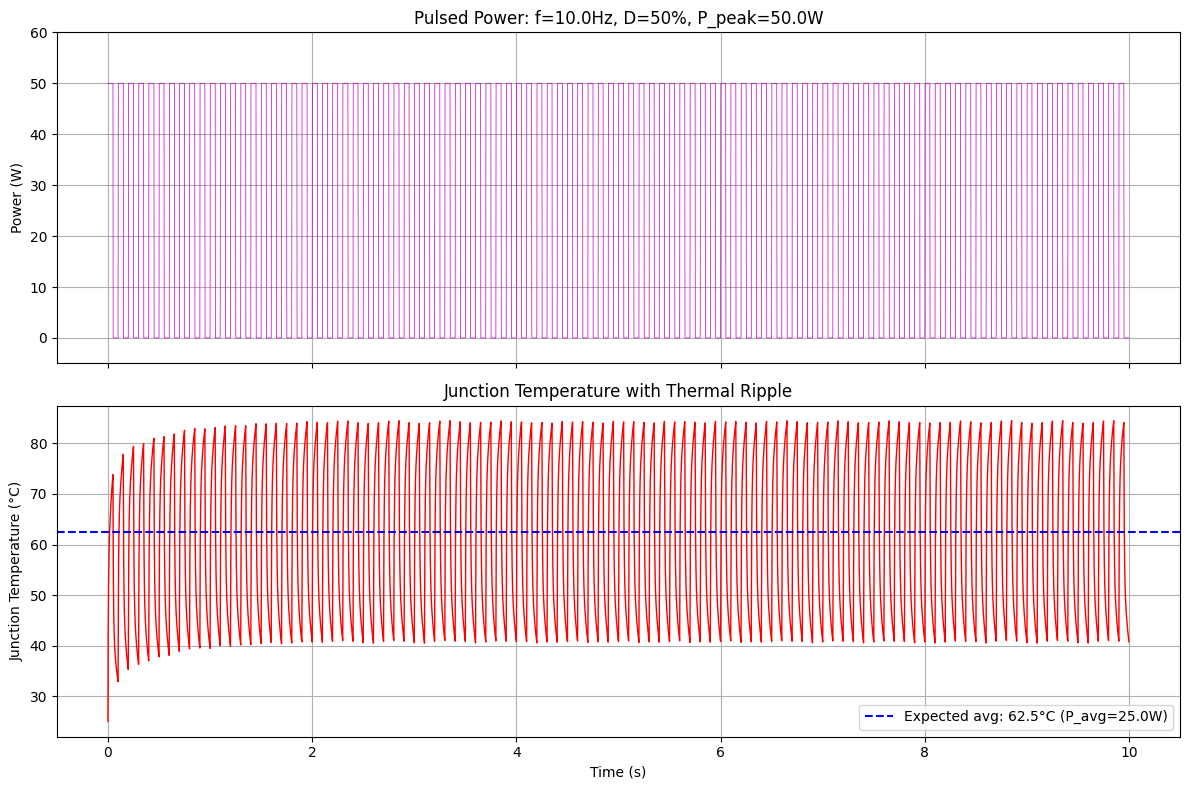


Pulsed Operation (Steady State):
  Average power: 25.0W
  Peak junction temperature: 84.5°C
  Minimum junction temperature: 40.5°C
  Average junction temperature: 62.5°C
  Temperature ripple (peak-to-peak): 43.95°C


In [15]:
# Simulate pulsed power (PWM-like operation)
simulator_pulsed = ps.ThermalSimulator(thermal_network, T_ambient)

# Parameters
P_peak = 50.0  # Peak power during ON time
f_sw = 10.0  # 10 Hz for visualization (thermal time constants are slow)
duty_cycle = 0.5  # 50% duty cycle
T_period = 1.0 / f_sw

# Create pulsed power waveform
t_end = 10.0  # 10 seconds (100 cycles)
dt_pulsed = 0.001  # 1ms timestep
times_pulsed = np.arange(0, t_end, dt_pulsed)

# Generate PWM power waveform
powers_pulsed = np.where((times_pulsed % T_period) < (T_period * duty_cycle), P_peak, 0.0)

# Run simulation
Tj_pulsed = simulator_pulsed.simulate(times_pulsed.tolist(), powers_pulsed.tolist())
Tj_pulsed = np.array(Tj_pulsed)

# Plot results
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Power waveform
axes[0].plot(times_pulsed, powers_pulsed, 'm-', linewidth=0.5)
axes[0].set_ylabel('Power (W)')
axes[0].set_title(f'Pulsed Power: f={f_sw}Hz, D={duty_cycle*100:.0f}%, P_peak={P_peak}W')
axes[0].grid(True)
axes[0].set_ylim([-5, P_peak * 1.2])

# Temperature response
axes[1].plot(times_pulsed, Tj_pulsed, 'r-', linewidth=1)
P_avg = P_peak * duty_cycle
Tj_avg_expected = T_ambient + P_avg * thermal_network.total_Rth()
axes[1].axhline(y=Tj_avg_expected, color='b', linestyle='--', 
                label=f'Expected avg: {Tj_avg_expected:.1f}°C (P_avg={P_avg}W)')
axes[1].set_ylabel('Junction Temperature (°C)')
axes[1].set_xlabel('Time (s)')
axes[1].set_title('Junction Temperature with Thermal Ripple')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Analyze steady-state ripple (last few cycles)
ss_mask = times_pulsed > 8.0
Tj_ss = Tj_pulsed[ss_mask]
Tj_peak = np.max(Tj_ss)
Tj_min = np.min(Tj_ss)
Tj_avg = np.mean(Tj_ss)
Tj_ripple = Tj_peak - Tj_min

print(f"\nPulsed Operation (Steady State):")
print(f"  Average power: {P_avg:.1f}W")
print(f"  Peak junction temperature: {Tj_peak:.1f}°C")
print(f"  Minimum junction temperature: {Tj_min:.1f}°C")
print(f"  Average junction temperature: {Tj_avg:.1f}°C")
print(f"  Temperature ripple (peak-to-peak): {Tj_ripple:.2f}°C")

## Summary

In this notebook, we covered:
- **Foster thermal networks** using `FosterNetwork` with Rth and tau values from datasheets
- **Thermal impedance curves** with `FosterNetwork.Zth(t)` method
- **Time-domain simulation** using `ThermalSimulator` with exponential integration
- **Temperature-dependent parameters** using `MOSFETLossParams.Rds_on_at_T()`
- **Thermal limit monitoring** with `ThermalLimitMonitor` for warning/max temperature tracking
- **Pulsed power analysis** showing temperature ripple in switching applications

Key classes:
- `FosterStage` - Single stage with Rth and tau
- `FosterNetwork` - Multi-stage thermal network
- `ThermalSimulator` - Time-domain thermal simulation
- `ThermalLimitMonitor` - Temperature limit tracking
- `MOSFETLossParams` - Temperature-dependent MOSFET parameters

Helper functions:
- `create_mosfet_thermal_model()` - Create typical MOSFET thermal model
- `create_simple_thermal_model()` - Single-stage simplified model
- `create_from_datasheet_4param()` - 4-parameter Foster network from datasheet

**Next:** [Parameter Sweeps Tutorial](04_parameter_sweeps.ipynb)